## Comparison-0-group-wise-protein-groups

> sample-wise

In [1]:
import pandas as pd
import numpy as np
import pyteomics.auxiliary as aux
import seaborn as sns
import matplotlib.pyplot as plt
import os, re, subprocess
from utility_functions import *

In [2]:
DATE, project_palette

('20250627',
 {'canon': 'orangered', 'trembl': 'yellowgreen', 'openprot': 'cornflowerblue'})

In [3]:
# def get_max_psm_score(x):
#     protein_group = x.split(',')
#     tmp3 = psms[psms.proteins.isin(protein_group)]
#     return np.max(tmp3.psm_score)

# def group_is_decoy(x):
#     protein_group = x.split(',')
#     tmp = [_.startswith('decoy') for _ in protein_group]
#     return set(tmp)

# def classify_protein_group(x):
#     protein_group = x.split(',')
#     tmp = [classify_leadprot(_) for _ in protein_group]
#     return is_peptide_canonical(tmp)

# def classify_leadprot(x):
#     if 'CONTAMINANT' in x.upper():
#         return 'Contam'
#     # elif x.endswith('_p_target'):
#     #     return 'Target'
#     elif x.startswith('II_') or x.startswith('IP_'):
#         return 'NonCanon'
#         # Ensembl is canonical
#     else:
#         return 'Canon'

# def is_peptide_canonical(x):
#     '''x is the list of protein classes'''
#     if np.array([_=='Contam' for _ in x]).any():
#         return 'Contam'
#     if np.array([_=='Target' for _ in x]).any():
#         return 'Target'
#     if np.array([_=='Canon' for _ in x]).any():
#         return 'Canon'
#     return 'NonCanon'

# def classifiy_mods(row):
#     if row.modifications=='Unmodified':
#         return 'Unmod'
#     elif len(row.unexpected_modification)>1:
#         return 'Unexpected'
#     else:
#         return 'Expected'

# def custom_subgroup_filter(data_):
#     FDRgroups = []
#     for _,df in data_.groupby('FDRGroup').__iter__():
#         tmp = aux.target_decoy.qvalues(df, key='psm_score', reverse=True, is_decoy=df.database=='D',
#                                        q_label='custom_q', formula=1, full_output=True)
#         FDRgroups.append(tmp)
#     return pd.concat(FDRgroups, ignore_index=True)

In [4]:
working_folder = "C:/Users/Enrico/OneDrive - UGent/run-ionbot"
savefig_path = f"publication-data/{DATE}-group-wise-protgroups.svg"
savefile_path = f'publication-data/{DATE}-identified-protein-groups-all-datasets.csv.gz'
PXDs = [
    'PXD002057.v0.11.4',
    'PXD005833.v0.11.4',
    'PXD014258.v0.11.4',
]
# savefile_path = f'publication-data/{DATE}-identified-protein-groups-all-datasets-closed.csv.gz'
# savefig_path = f"publication-data/{DATE}-group-wise-protgroups-closed.svg"
# PXDs = [
#     'PXD002057-closed',
#     'PXD005833-closed',
#     'PXD014258-closed',
# ]
SEARCHES = [
    'canon',
    'trembl',
    'openprot',
]
DATASETS = pd.MultiIndex.from_product([PXDs,SEARCHES])
DATASETS

MultiIndex([('PXD002057.v0.11.4',    'canon'),
            ('PXD002057.v0.11.4',   'trembl'),
            ('PXD002057.v0.11.4', 'openprot'),
            ('PXD005833.v0.11.4',    'canon'),
            ('PXD005833.v0.11.4',   'trembl'),
            ('PXD005833.v0.11.4', 'openprot'),
            ('PXD014258.v0.11.4',    'canon'),
            ('PXD014258.v0.11.4',   'trembl'),
            ('PXD014258.v0.11.4', 'openprot')],
           )

In [5]:
folders = {search:{dataset_name:[] for dataset_name in PXDs} for search in SEARCHES}
for dataset_name in PXDs:
    for search in SEARCHES:   
        for fld in os.scandir(os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}")):
            if not fld.name.startswith('.') and os.path.isdir(fld.path): 
                folders[search][dataset_name].append(fld)
# folders

In [6]:
output_files = []
for dataset_name in PXDs:
    for search in SEARCHES:  
        j = len(folders[search][dataset_name])
        for i,sample_fld in enumerate(folders[search][dataset_name]):            
            # Read and preprocess the dataset
            psms = pd.read_csv(os.path.join(sample_fld.path,'ionbot.first.csv'))
            print(f'({1+i}/{j})',sample_fld, psms.shape)
            psms = pd.read_csv(os.path.join(sample_fld.path,'ionbot.first.csv'))
            psms.modifications = psms.modifications.fillna('')
            psms = psms[psms['q-value']<=.01].copy(deep=True)
            psms.proteins = psms.proteins.str.split('||', regex=False)
            psms.proteins = psms.proteins.apply(lambda x: [re.split(r'\(\(|\)\)', _)[3] for _ in x])
            psms.proteins = psms.proteins.apply(lambda x: [re.sub(r'^sp\|','',_) for _ in x])
            psms.proteins = psms.proteins.apply(lambda x: list(set(x)))
            # try without contaminant peptides
            psms['protein_classes'] = psms.proteins.apply(lambda x: np.unique([classify_leadprot(_) for _ in x]))
            psms['isCanonical'] = psms.protein_classes.apply(is_peptide_canonical)
            psms = psms.copy(deep=True)
            psms.proteins = psms.apply(lambda row: row.proteins if row.database=='T' else [f'decoy_{_}' for _ in row.proteins] , axis=1)
            # print(psms.proteins.apply(len).describe())
        
            with open(os.path.join(sample_fld.path, "sample-protein-inference-input.pout"), 'w') as POUT:
                for _,row in psms[(psms.isCanonical!='Contam')&(psms.proteins.apply(len)<1000)].iterrows():
                    row2 =  [row.ionbot_match_id, row.spectrum_title, f"{row['q-value']:.2e}", 
                             row.modifications, f"{row.charge}.{row.matched_peptide}"]
                    row2 += [f'>xx|{_}|placeholder' if '|' not in _ else _ for _ in row.proteins]
                    row2 =  '\t'.join(row2) + '\n'
                    POUT.write(row2)
        
            pout_file = os.path.join(sample_fld.path, "sample-protein-inference-input.pout")
            groups_file = os.path.join(sample_fld.path, "groups_Occam.tsv")
            subgroups_file = os.path.join(sample_fld.path, "subgroups_Occam.tsv")
            _ = subprocess.run(['pout2prot', '--occam', pout_file, groups_file, subgroups_file])
            print('Run pout2prot:',_.returncode==0)  
        
            # Make "summary" table to get max psm score
            psms = psms[['proteins','psm_score']].copy(deep=True)
            psms = psms.explode('proteins')
            psms.sort_values('psm_score', ascending=False, inplace=True)
            psms.drop_duplicates('proteins', inplace=True)
        
            # calculate protein groups scores
            protein_groups = pd.read_csv(groups_file, sep='\t', usecols=['protein accessions'])
            protein_groups.columns = ['proteins']
            protein_groups['psm_score'] = protein_groups.proteins.apply(lambda x: get_max_psm_score(x,psms))
        
            # label decoys
            protein_groups['isDecoy_'] = protein_groups.proteins.apply(group_is_decoy)
            protein_groups['database'] = protein_groups.isDecoy_.apply(lambda x: 'D' if list(x)[-1] else 'T')
    
            protein_groups = protein_groups[['proteins','database','psm_score']].copy(deep=True)
            protein_groups['experiment'] = sample_fld.name
            protein_groups['exp_number'] =  f'{dataset_name} exp {i+1}' #'-'.join(sample_fld.name.split('-')[:-1])
            protein_groups['PXD'] = dataset_name
            protein_groups['searchDB'] = search
        
            # recalculate q-values
            protein_groups = aux.target_decoy.qvalues(protein_groups, key='psm_score', reverse=True, 
                                                      is_decoy=protein_groups.database=='D',
                                                      q_label='q-value', formula=1, full_output=True)
        
            protein_groups['isCanonical'] = protein_groups.proteins.apply(classify_protein_group)
            protein_groups['isModified'] = 'NA'
            protein_groups = custom_subgroup_filter(protein_groups)
            out_path = os.path.join(sample_fld.path, "sample_protein_groups_Occam.csv")
            protein_groups.to_csv(out_path, index=False)
            output_files.append(out_path)

(1/6) <DirEntry '130327_o2_01_hu_C1_2hr.mgf.gzip'> (18841, 17)
Run pout2prot: True
(2/6) <DirEntry '130327_o2_02_hu_P1_2hr.mgf.gzip'> (19903, 17)
Run pout2prot: True
(3/6) <DirEntry '130327_o2_03_hu_C2_2hr.mgf.gzip'> (16842, 17)
Run pout2prot: True
(4/6) <DirEntry '130327_o2_04_hu_P2_2hr.mgf.gzip'> (19056, 17)
Run pout2prot: True
(5/6) <DirEntry '130327_o2_05_hu_C3_2hr.mgf.gzip'> (16973, 17)
Run pout2prot: True
(6/6) <DirEntry '130327_o2_06_hu_P3_2hr.mgf.gzip'> (19109, 17)
Run pout2prot: True
(1/6) <DirEntry '130327_o2_01_trembl'> (19091, 17)
Run pout2prot: True
(2/6) <DirEntry '130327_o2_02_trembl'> (20111, 17)
Run pout2prot: True
(3/6) <DirEntry '130327_o2_03_trembl'> (17067, 17)
Run pout2prot: True
(4/6) <DirEntry '130327_o2_04_trembl'> (19230, 17)
Run pout2prot: True
(5/6) <DirEntry '130327_o2_05_trembl'> (17235, 17)
Run pout2prot: True
(6/6) <DirEntry '130327_o2_06_trembl'> (19285, 17)
Run pout2prot: True
(1/6) <DirEntry '130327_o2_01_hu_C1_2hr-openprot'> (19845, 17)
Run pout2prot

-----

In [7]:
combo = [pd.read_csv(_) for _ in output_files]
combo = pd.concat(combo, ignore_index=True)
combo.rename(columns={'q-value':'global_qvalue','custom_q':'groupwise_qvalue','group_qval':'GroupWalk_q'}, inplace=True)
combo.to_csv(savefile_path, index=False, compression='gzip')

print('Without filtering:')
data = pd.read_csv(savefile_path)
T, D = data.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

print('After filtering:')
data_filtered = data[data.global_qvalue<.01].copy(deep=True)
T, D = data_filtered.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

print('After Custom filtering:')
data_filtered = data[data.groupwise_qvalue<.01].copy(deep=True)
T, D = data_filtered.database.value_counts()
print('Targets, Decoys =',[T,D],f"FDR = {D/T:.2%}")

Without filtering:
Targets, Decoys = [129500, 9725] FDR = 7.51%
After filtering:
Targets, Decoys = [112840, 1096] FDR = 0.97%
After Custom filtering:
Targets, Decoys = [114323, 1073] FDR = 0.94%


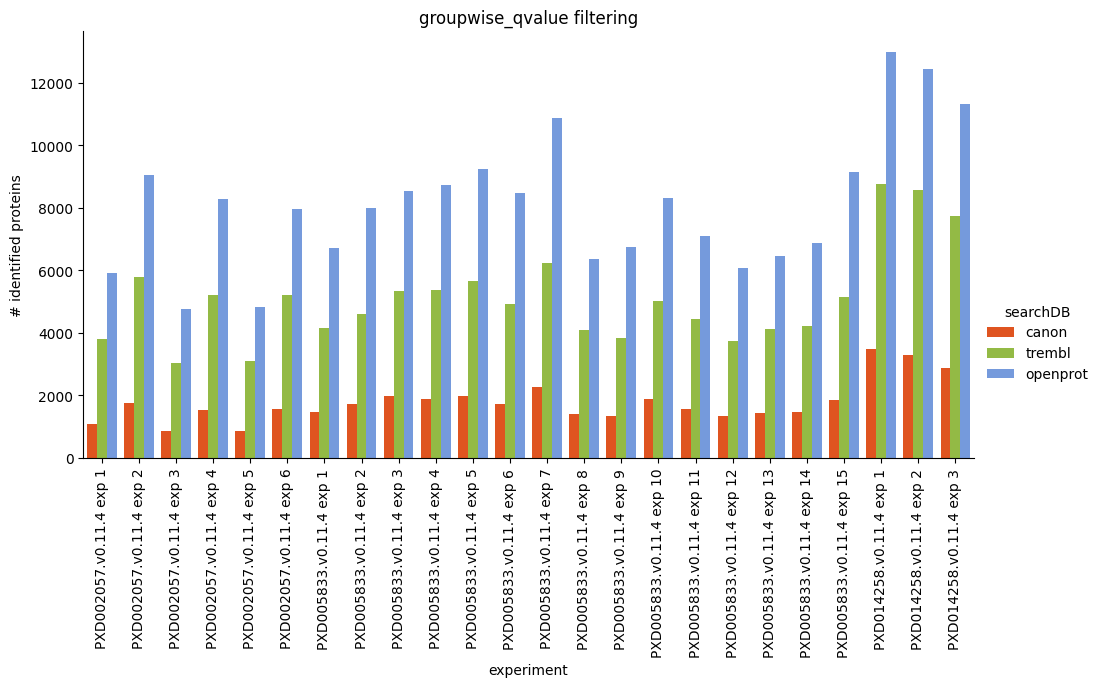

In [8]:
tmp = 'groupwise_qvalue'
combo = combo[(combo[tmp]<.01)&(combo.database=='T')&(combo.isCanonical!='Contam')]
combo.proteins = combo.proteins.str.split(',')
combo = combo.explode('proteins')
combo.drop_duplicates(['proteins','experiment','searchDB'], inplace=True)

sns.catplot(data=combo, kind='count', x='exp_number', hue='searchDB', aspect=2, palette=list(project_palette.values()))
plt.xticks(rotation=90)
plt.xlabel('experiment')
plt.ylabel('# identified proteins')
plt.title(f'{tmp} filtering')

plt.savefig(savefig_path, dpi=300, bbox_inches='tight')

----